In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import copy

The first task is to create a random strongly connected network with colored edges

In [ ]:
# Variable settings
num_nodes = 6
num_edges = 10
num_colors = 3

In [ ]:
def create_graph(num_nodes,num_edges,num_colors):
  """Returns a strongly connected graph with a specified number of nodes, edges, and colored edges"""
  strong = False
  while not strong:
    # Create graph
    G = nx.DiGraph()
    G.add_nodes_from(range(num_nodes))

    # Calculate possible edges-- this does not inlcude self referential edges
    all_possible_edges = [(i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j]
    random.shuffle(all_possible_edges)

    # selects the specified number of edges and adds them to the graph
    edges_to_add = all_possible_edges[:num_edges]
    G.add_edges_from(edges_to_add)

    # Checks if the graph is strongly connected
    strong = nx.is_strongly_connected(G)
  # Assign random colors to edges
  edge_colors = [random.randint(0, num_colors - 1) for _ in range(len(G.edges))]
  edge_color_map = dict(zip(G.edges(), edge_colors))
  nx.set_edge_attributes(G,edge_color_map,'color')

  return G




In [ ]:
graph = create_graph(num_nodes,num_edges,num_colors)

In [ ]:
def visualize_graph(G):
  """Draws a graph with colored edges, provides a legend"""
  colors = [data['color'] for _, _, data in G.edges(data=True)]
  cmap = plt.get_cmap('viridis')
  norm = mcolors.Normalize(vmin=min(colors), vmax=max(colors))
  edge_colors = [cmap(norm(color)) for color in colors]
  unique_colors = sorted(set(colors))
  patches_list = [patches.Patch(color=cmap(norm(color)), label=f'Color {color}') for color in unique_colors]
  pos = nx.spring_layout(G) #Usually uses spring
  nx.draw(G, pos, with_labels=True, edge_color=edge_colors, width=2, node_size=500, connectionstyle='arc3, rad = 0.05')
  plt.legend(handles=patches_list, title="Edge Colors")
  plt.show()


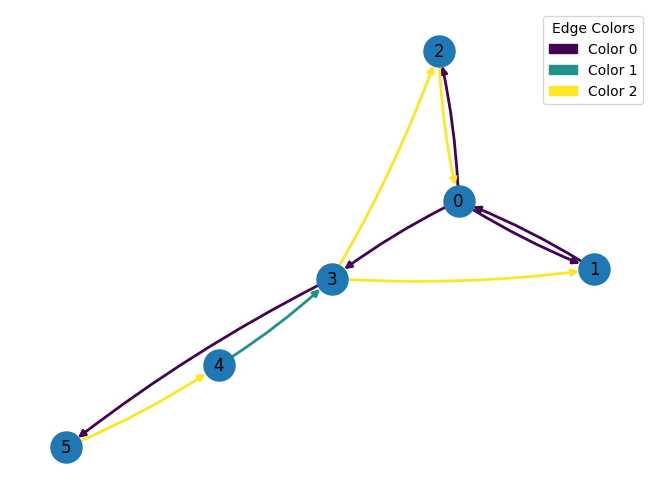

In [ ]:
visualize_graph(graph)

In [ ]:
def draw_subnetwork(G, subnetwork_nodes, title):
    """Draw a single subnetwork, this function is called as part of visualize_subnetworks"""
    subgraph = G.subgraph(subnetwork_nodes)
    pos = nx.spring_layout(subgraph)  # Position nodes using the spring layout
    edges = subgraph.edges()
    labels = nx.get_edge_attributes(subgraph, 'color')

    plt.figure(figsize=(8, 6))
    nx.draw(subgraph, pos, with_labels=True, edge_color='gray', arrows=True)
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels, font_color='red')
    plt.title(title)
    plt.show()

def visualize_subnetworks(G, subnetworks):
  """Plots all of the subnetworks found by find_subnetworks"""
  for i, subnetwork in enumerate(subnetworks):
      draw_subnetwork(G, subnetwork, f'Subnetwork {i + 1}')

Now that the graph has been created we will implement the subnetwork search algorithm

Algorithmic path:
* Choose a node
* identify all edges flowing into the node
* make a set of all the colors flowing into the node
* choose an element of the set of colors
* make a set of edges that have been chosen and one for not chosen
* add the node to the set of visited nodes
* move to the chosen node
* repeat until the next node appears in the set of visited nodes or you cannot go any further

* work down each level then  back track to the next lowest edge that hasn't been chosen

* when a subnetwork is finished go back to the last place you had a choice
* every element of a subnetwork only has one color going into it



 Questions to be answered:
 * is there a difference between depth first and breadth first code
 * precedence between same color divergence and different color divergence? take same color route in same sub network, different color choice in different subnetworks
 * try a monte carlo method to randomly delete edges until each node only has one edge

Implementation of the algorithm without colors

In [ ]:
def find_subnetworks(G,start,visited=None,current_subnetwork=None):
  """Algorithm recursively finds subnetworks, this version does not take into account edge colors"""
  # Base cases
  if visited is None:
    visited = set()
  if current_subnetwork is None:
    current_subnetwork = []
  # Adds current node to both visited and current subnetwork
  visited.add(start)
  current_subnetwork.append(start)
  # Finds all incoming edges
  incoming_edges = list(G.in_edges(start))
  subnetworks = []
  # u and v are each nodes which are connected by one of the edges in incoming_edges
  for u,v in incoming_edges:
    # checks if u has alread been evaluated
    if u not in visited:
      # If u was not evaluated it is used as the starting node in a new search
      new_subnetworks = find_subnetworks(G,u,visited.copy(),current_subnetwork.copy())
      # the results of the new search are added to the subnetworks
      subnetworks.extend(new_subnetworks)
    else:
      # This logic deals with when there is a loop
      if u in current_subnetwork:
        loop_subnetwork = current_subnetwork + [u]
        subnetworks.append(loop_subnetwork)
  # removes the current network once it has been fully explored
  current_subnetwork.pop()
  # allows for the same node to appear in different subnetworks
  visited.remove(start)
  # stops when there are no more unexplored paths
  if not incoming_edges or not subnetworks:
    return [current_subnetwork]
  # subnetworks is a list of all subnetworks
  return subnetworks



In [ ]:
subnetworks = find_subnetworks(graph,1)

While this algorithm functions as expected its temporal complexity is $ \in O(2^n)$

We now add colors to the algorithm

In [ ]:
def find_subnetworks_color(G,start,visited=None,current_subnetwork=None):
  """Implementation very similar to above, with the exception of the logic which is implemented to deal with colors"""
  # Base cases
  if visited is None:
    visited = set()
  if current_subnetwork is None:
    current_subnetwork = []
  # Adds current node to both visited and current subnetwork
  visited.add(start)
  current_subnetwork.append(start)
  # Finds all incoming edges
  incoming_edges = list(G.in_edges(start,data=True))
  color_groups = {}
  # This section creates a dictionary of all the colors flowing into the node
  for u,v, data in incoming_edges:
    color = data.get('color')
    if color not in color_groups:
      color_groups[color] = []
    color_groups[color].append(u)
  # Starts a subnetworks list, each subnetwork will be appended once it has been fully explored
  subnetworks = []
  # This section is essentially the same as before, except now it does all edges of the same color at the same time
  # Check that this actually works when there are multiple edges of the same color flowing into a node
  for color, nodes in color_groups.items():
    for u in nodes:
      if u not in visited:
        new_subnetworks = find_subnetworks_color(G, u, visited.copy(), current_subnetwork.copy())
        subnetworks.extend(new_subnetworks)
      else:
        # Deals with loops
        if u in current_subnetwork:
          loop_subnetwork = current_subnetwork + [u]
          subnetworks.append(loop_subnetwork)
  # Moves on to the next subnetwork and clears the variables that need to reset
  current_subnetwork.pop()
  visited.remove(start)
  # Stopping criteria
  if not incoming_edges or not subnetworks:
    return [current_subnetwork]
  return subnetworks


In [ ]:
subnetworks = find_subnetworks_color(graph,3)

In [ ]:
print(subnetworks)

[[3, 4, 5, 3], [3, 0, 2, 3], [3, 0, 2, 0], [3, 0, 1, 0], [3, 0, 1, 3]]


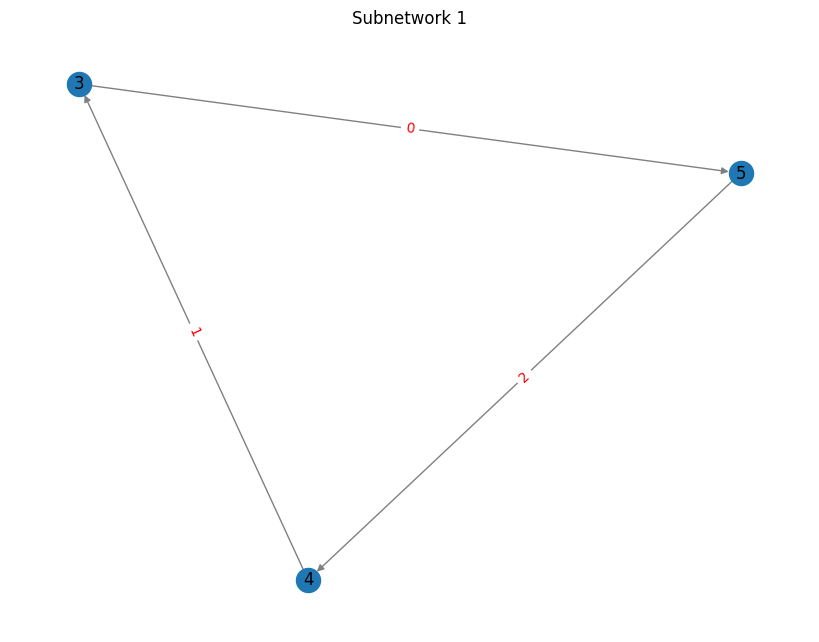

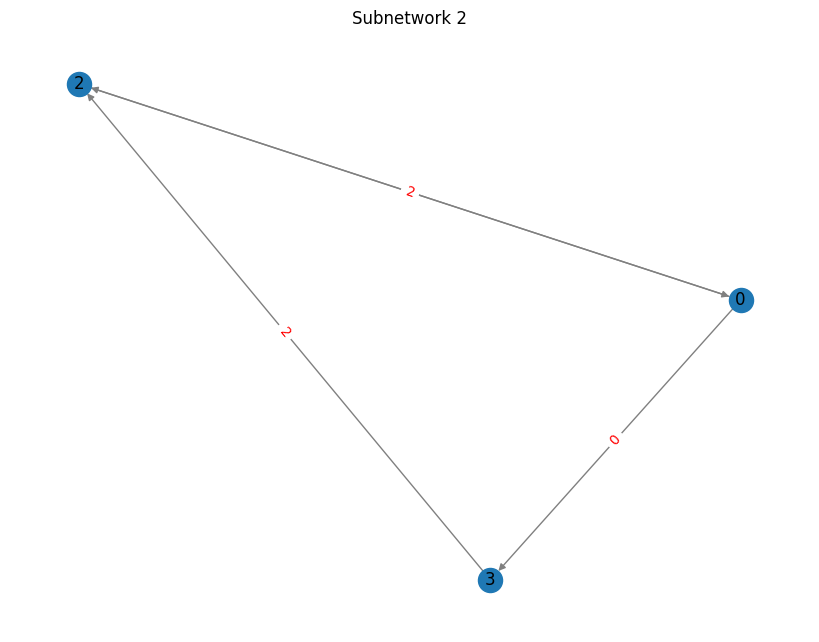

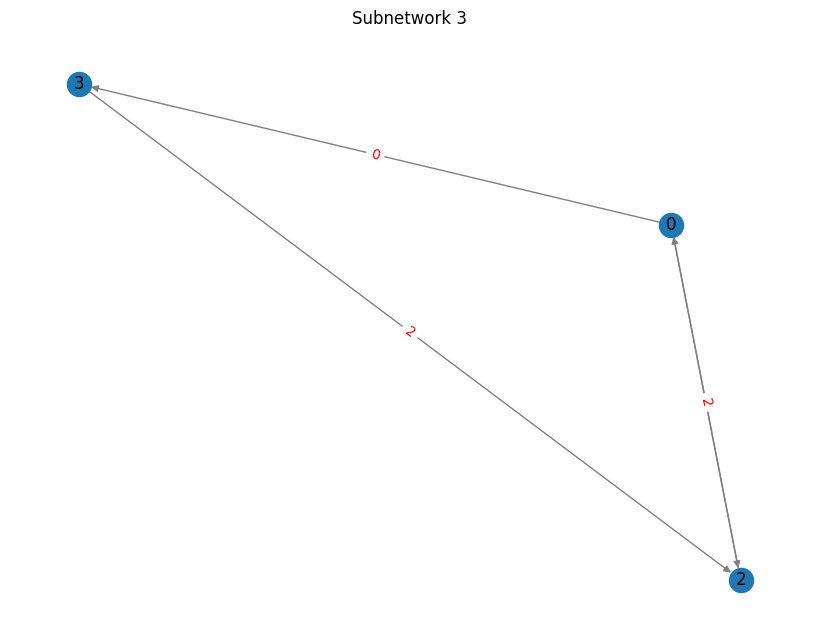

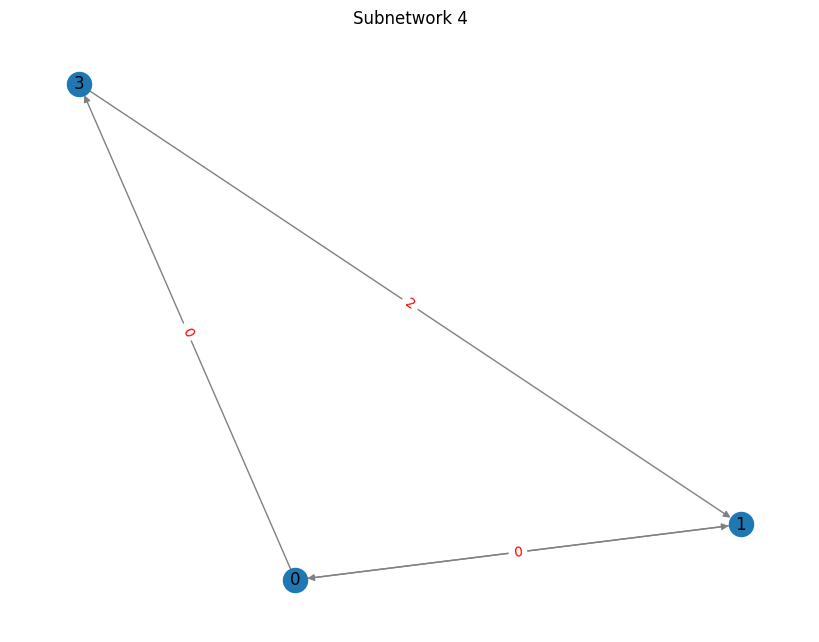

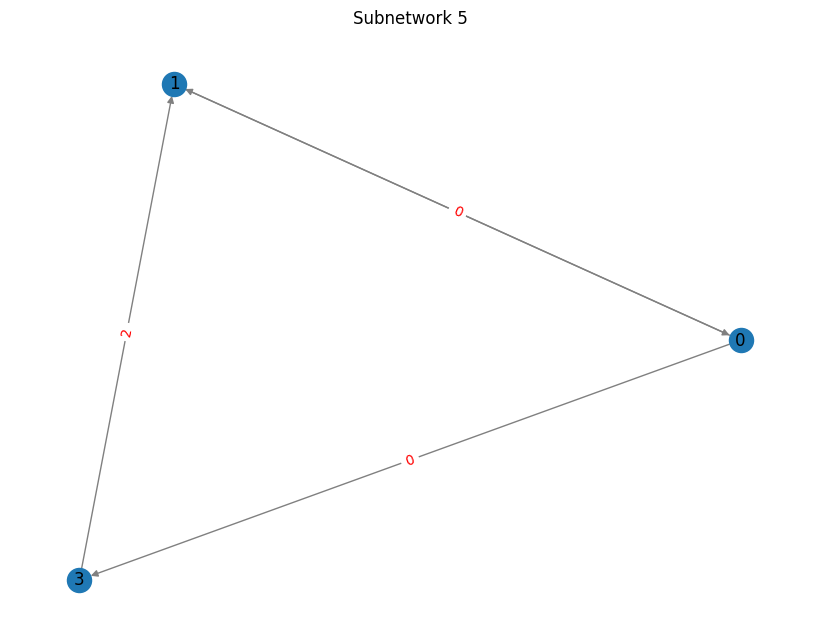

In [ ]:
visualize_subnetworks(graph,subnetworks)

The next step is to create a weighted adjacency matrix so that we can calculate eigen values

In [ ]:
def create_weights(G):
  n = num_nodes
  matrix = np.random.rand(n,n)
  column_sums = matrix.sum(axis=0)
  column_sums[column_sums == 0] = 1
  normed = matrix / column_sums
  return normed


In [ ]:
weighted = create_weights(graph)
print(weighted)

[[0.14377685 0.03170652 0.13834676 0.24844484 0.05116971 0.35485678]
 [0.1289084  0.172523   0.1669907  0.11722748 0.07628656 0.13263049]
 [0.20292045 0.11163285 0.08626677 0.05066614 0.28778489 0.2466846 ]
 [0.27490124 0.28486691 0.05791925 0.28537551 0.29337484 0.14990583]
 [0.21305909 0.18903419 0.36654788 0.22763504 0.24483904 0.05863957]
 [0.03643398 0.21023653 0.18392864 0.07065099 0.04654497 0.05728273]]


Here we create a function to determine the spectral radius of each subnetwork, at this point the graphs are unweighted

In [ ]:
def spectral_radius(weighted,subnetworks):
  radii = []
  for subnetwork in subnetworks:
    subnetwork_matrix = weighted[np.ix_(subnetwork,subnetwork)]
    rho = max(abs(np.linalg.eigvals(subnetwork_matrix)))
    radii.append(rho)

  return radii

In [ ]:
print(spectral_radius(weighted,subnetworks))

[0.9590369992423635, 1.3124129435909673, 0.49466402154862416]


Here we set up an experiment to determine if the spectral radii of the subnetworks are dependent on which node is used as the starting node

In [ ]:
for i in range(num_nodes):
  subnetworks  = find_subnetworks_color(graph,i)
  print(f'Node {i}')
  print(spectral_radius(weighted,subnetworks))

Node 0
[1.1301129852463412, 0.7251310379740334, 0.44435125816775917, 0.3371947259022831, 1.1380327762718518, 0.7398234802651283]
Node 1
[1.2507453447768686, 0.8205730983832917, 0.5137730863929294, 0.3796955404565074, 0.9610520697129907, 0.9323563508690123, 0.8205730983832918, 0.7072693508496776]
Node 2
[0.9366433049008469, 0.5936554406975124, 0.8205730983832916, 0.9323563508690109, 0.39554414251048375, 0.5137730863929286, 1.250745344776869, 0.8205730983832915]
Node 3
[0.8371315243027724, 0.8158449623833874, 0.7251310379740326, 0.7398234802651288, 0.8881222662370041]
Node 4
[0.7872165875560101, 1.130112985246339, 1.039487518221867, 0.9840477613672755, 1.1380327762718505]
Node 5
[0.5781032536067247, 0.8892040752331187, 0.8277028489875045, 0.8357224292111884, 0.9584718094619298]


Large scale experiment testing multiple graphs

In [ ]:
num_graphs = 10
num_colors = 3
for j in range(num_graphs):
  num_nodes = 4
  num_edges = 6
  graph = create_graph(num_nodes,num_edges,num_colors)
  weighted = create_weights(graph)
  print(j)
  print(f'Nodes:{num_nodes}')
  for i in range(num_nodes):
    subnetworks  = find_subnetworks(graph,i)
    print(f'Node {i} number of subnetworks = {len(subnetworks)}')
    print(spectral_radius(weighted,subnetworks))


0
Nodes:4
Node 0 number of subnetworks = 3
[1.1294255076825346, 1.443612428663053, 0.9233333019620449]
Node 1 number of subnetworks = 3
[0.8436485753025442, 1.1294255076825341, 0.4434986998075]
Node 2 number of subnetworks = 3
[0.7703086482510968, 1.2515207158424988, 0.3071741766235847]
Node 3 number of subnetworks = 4
[0.9773551703896457, 0.8436485753025444, 1.2064131354262586, 1.1294255076825341]
1
Nodes:4
Node 0 number of subnetworks = 4
[0.9621273722133901, 0.9883961187239823, 1.0468071517867696, 1.1903063209008065]
Node 1 number of subnetworks = 3
[0.9883961187239835, 1.190306320900806, 0.7847424694011844]
Node 2 number of subnetworks = 3
[1.1903063209008082, 0.9432549015562735, 0.8964192793179491]
Node 3 number of subnetworks = 3
[0.8697213580505574, 0.9336285052268262, 0.517061780496655]
2
Nodes:4
Node 0 number of subnetworks = 3
[1.136381720470415, 1.2941602394070824, 1.326476579149674]
Node 1 number of subnetworks = 3
[0.8255690266380672, 0.9480199030320906, 1.2181243778355728

It was surprisingly found that starting at different nodes yielded not only different spectral radii, but also occasionally a different number of subnetworks would be returned.
Experiment 1:
10 graphs: 5 yielded different numbers of subgraphs, of the remaining five, none of the differences in eigen values would have affected the outcome of the flow.
Experiment 2:
20 graphs: 10  with different subnetworks, 7 with different futures

Experiment 3:
20 graphs 4 nodes 6 edges:
11 different subnetworks, 20 different futures

Experiment 4:
5 graphs, 20 nodes, 30 edges
all 5 had different subnetworks

Experiment 5:
5 graphs, 3 colors, 30 edges
all five had different numbers of subnetworks


To do:
* check functionality of algorithm when more than one edge flowing into a node are of the same color
* use the edges to check whether the returned subnetworks are different or the same
* check if any of the subnetworks starting at the same vertex are a subset of each other
* what happens if you erase every edge that doesn't branch

* proof that depth and breadth first searches return the same thing

What if you create a different matrix for each color, and then per node you look at the entries corosponding to the node of interest??

Implementation of a breadth first approach

In [2]:
def breadth_first(G,starting_node):
    """This function is a breadth first approach to identifying subnetworks, it iterates through each subnetwork in working_subnetworks, adding a single level
    this could be more than a single edge/node pair if the edge is connected to more than one other node via edges of the same color. Once the stopping criteria are met the
    subnetwork is popped off and added to completed_subnetworks"""
    """Psuedo code:
    Create a subnetwork containing the starting node, add it to working_subnetworks, record it in visited_nodes
    for every subnetwork in working subnetworks
    for each of the nodes in the last entry (just in case more than node flowed into the predecessor with the same color,this should usually be only one node)
    find all of the nodes which flow into that node and group them by color
    for each of the colors, check if the nodes have been visited
    if they have, add them to the graph, add it to the completed_subnetworks, and remove the graph from working_subnetworks
    if not add them to a copy of a subnetwork and remove the original
    when working_subnetworks is empty return the completed_subnetworks
    """
    # Initialize lists
    completed_subnetworks = []
    working_subnetworks = []

    # We add each element as a list
    working_subnetworks.append([[starting_node],[starting_node]])

    visited = False

    # Loop through each subnetwork, adding one node to each network and popping of networks once they are finished
    while working_subnetworks:
        # We work on each subnetwork individually
        for subnetwork in working_subnetworks:
            # This should pop the current subnetwork not the first one
            index = working_subnetworks.index(subnetwork)
            working_subnetworks.pop(index)
            working_level = subnetwork[0][-1]
            if isinstance(working_level,list):
                k = len(working_level)
            else:
                k = 1
            for i in range(k):
                if isinstance(working_level, list):
                    node = working_level[i]
                else:
                    node = working_level
                # Collect all incoming edges
                incoming_edges = list(G.in_edges(node,data = True))
                # Creates a dictionary of all colors flowing into a node
                color_groups = {}
                for u, v, data in incoming_edges:
                    color = data.get('color')
                    if color not in color_groups:
                        color_groups[color] = []
                    color_groups[color].append(u)
                # for each of the color groups we create a copy of the subnetwork and append all of the nodes in that group
                for key in color_groups.keys():
                    # using deep copy ensures that the correct subnetworks are modified
                    new_subnetwork = copy.deepcopy(subnetwork)
                    for value in color_groups[key]:
                    # we need to check if the nodes are already in visited
                        if value in new_subnetwork[1]:
                            visited = True
                        else:
                            new_subnetwork[1].append(value)
                    if visited:
                        new_subnetwork[0].append(color_groups[key])
                        completed_subnetworks.append(new_subnetwork[0])
                        visited = False
                    else:
                        new_subnetwork[0].append(color_groups[key])
                        working_subnetworks.append(new_subnetwork)
    final = []
    for network in completed_subnetworks:
        flat = []
        stack = list(network)
        while stack:
            item = stack.pop()
            if isinstance(item,list):
                stack.extend(item)
            else:
                flat.append(item)
        final.append(flat[::-1])
    return final